In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

data = pd.read_csv("data/data_health/trace_activities.csv")


In [15]:
exclude_columns = [
    "traceId",
    "index",
    "activity",
    "start",
    "end",
    "EVENTID",
]

attributes = data.select_dtypes(
    include=["object", "category", "bool", "number"]
).columns.tolist()
selected_attributes = [attr for attr in attributes if attr not in exclude_columns]


In [16]:
# Identify attributes that do not vary within traces
def is_trace_level(attribute):
    return data.groupby("traceId")[attribute].nunique().max() == 1


# Filter out activity-level attributes
trace_level_attributes = [attr for attr in selected_attributes if is_trace_level(attr)]

# Aggregate the selected trace-level attributes for each trace
trace_attributes = data.groupby("traceId")[trace_level_attributes].first().reset_index()


In [17]:
data["start"] = pd.to_datetime(data["start"])
data["end"] = pd.to_datetime(data["end"])

trace_durations = (
    data.groupby("traceId")
    .agg(start_time=("start", "min"), end_time=("end", "max"))
    .reset_index()
)

trace_durations["total_duration"] = (
    trace_durations["end_time"] - trace_durations["start_time"]
).dt.total_seconds()

trace_attributes = data.groupby("traceId")[selected_attributes].first().reset_index()
trace_data = trace_durations.merge(trace_attributes, on="traceId")
trace_data.head()


,traceId,start_time,end_time,total_duration,CORDERID,EINRI,ENDDT,LSSTAE,MANDT,NOTKZ,STATU,STORN
0,00035269-393b-47ca-9e77-6f9626433e4f,2023-08-25 16:40:22,2023-08-28 04:48:49,216507.0,False,Badajoz,Cerrado,ER,Doctor_10,False,70.0,Empty
1,00042ec6-0f5c-469f-bcf4-32ea9de63d5f,2023-08-26 14:59:03,2023-08-26 15:58:42,3579.0,False,Teruel,Cerrado,DI,Doctor_4,True,True,Empty
2,000811dc-2bdb-4497-96bc-0688b4bb381a,2023-08-28 02:16:41,2023-08-28 03:15:03,3502.0,False,Castellon,Cerrado,UA,Doctor_1,True,True,Empty
3,00132b96-1cac-4c27-80b2-ad3b59290d43,2023-08-31 08:00:24,2023-09-02 14:43:18,196974.0,True,Badajoz,Cerrado,ER,Doctor_10,False,60.0,Empty
4,0014f473-8b72-4ecd-95d2-b33762db32c2,2023-08-25 11:42:54,2023-08-25 13:41:18,7104.0,True,Badajoz,Cerrado,UA,Doctor_9,False,50.0,Empty


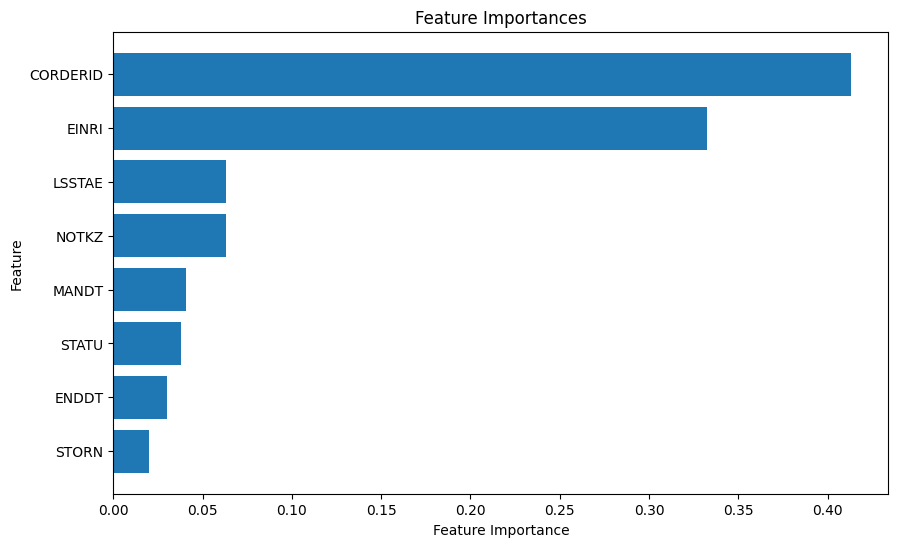

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in trace_data.select_dtypes(include=["object", "category"]).columns:
    le = LabelEncoder()
    trace_data[col] = le.fit_transform(trace_data[col])
    label_encoders[col] = le

X = trace_data.drop(columns=["traceId", "start_time", "end_time", "total_duration"])
y = trace_data["total_duration"]

model = RandomForestRegressor(random_state=42)
model.fit(X, y)

feature_importances = pd.DataFrame(
    {"feature": X.columns, "importance": model.feature_importances_}
).sort_values(by="importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(
    feature_importances["feature"],
    feature_importances["importance"].sort_values(ascending=True),
)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
plt.show()


In [19]:
threshold = 0.95
feature_importances["cumulative_importance"] = feature_importances[
    "importance"
].cumsum()

selected_features = feature_importances[
    feature_importances["cumulative_importance"] <= threshold
]["feature"].tolist()


,traceId,index,activity,start,end,CORDERID,EINRI,ENDDT,EVENTID,LSSTAE,MANDT,NOTKZ,STATU,STORN,activity_duration
0,049032b2-7422-4e24-af73-3a2d3e4e5b54,0,Create clinical order request,2023-08-28 14:02:23,2023-08-28 14:04:09,True,Teruel,Cerrado,b3ffe2af-c06e-491c-8e30-a6674b231249,ER,Doctor_1,False,50.0,Empty,106.0
1,049032b2-7422-4e24-af73-3a2d3e4e5b54,1,Plan clinical order,2023-08-28 14:06:07,2023-08-28 14:07:01,True,Teruel,Cerrado,cd9dd9b4-1286-45a1-90e7-351c83234cff,ER,Doctor_1,False,50.0,Empty,54.0
2,049032b2-7422-4e24-af73-3a2d3e4e5b54,2,Patient at reception desk,2023-08-30 16:35:18,2023-08-30 16:35:56,True,Teruel,Cerrado,9b063b8c-356f-4ed6-940c-874194ebe3b6,ER,Doctor_1,False,50.0,Empty,38.0
3,049032b2-7422-4e24-af73-3a2d3e4e5b54,3,Waiting room,2023-08-30 16:37:32,2023-08-30 16:51:15,True,Teruel,Cerrado,c1b137b0-7394-40bb-a120-633699a479a9,ER,Doctor_1,False,50.0,Empty,823.0
4,049032b2-7422-4e24-af73-3a2d3e4e5b54,4,Episode in treatment,2023-08-30 16:53:59,2023-08-30 17:02:18,True,Teruel,Cerrado,13c0622c-c402-4229-91a0-09eaedf04fa7,ER,Doctor_1,False,50.0,Empty,499.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78485,fe8a140e-d350-45cb-9bee-74b833ca95e9,1,Plan clinical order,2023-08-26 12:52:11,2023-08-26 12:56:02,True,Teruel,Cerrado,a0f4aa70-8fc5-4d76-901f-218741b56fca,QU,Doctor_5,False,60.0,Empty,231.0
78486,fe8a140e-d350-45cb-9bee-74b833ca95e9,2,Patient at reception desk,2023-08-29 07:29:30,2023-08-29 07:30:47,True,Teruel,Cerrado,a3913548-0b3b-4616-a0cc-c2284bedc57c,QU,Doctor_5,False,60.0,Empty,77.0
78487,fe8a140e-d350-45cb-9bee-74b833ca95e9,3,Waiting room,2023-08-29 07:33:25,2023-08-29 07:53:15,True,Teruel,Cerrado,e14d2816-1587-4a4f-a818-56f8def28113,QU,Doctor_5,False,60.0,Empty,1190.0
78488,fe8a140e-d350-45cb-9bee-74b833ca95e9,4,Episode in treatment,2023-08-29 07:54:37,2023-08-29 08:01:07,True,Teruel,Cerrado,cfcfcb32-d684-489f-bcb3-317d18369199,QU,Doctor_5,False,60.0,Empty,390.0


In [23]:
data["activity_duration"] = (data["end"] - data["start"]).dt.total_seconds()

data["activity_durations"] = data.groupby("traceId")["activity_duration"].transform(
    lambda x: [x.tolist()] * len(x)
)

data["transition_duration"] = (
    (data.groupby("traceId")["start"].shift(-1) - data["end"])
    .dt.total_seconds()
    .fillna(0)
    .astype(int)
)
data["transition_durations"] = data.groupby("traceId")["transition_duration"].transform(
    lambda x: [x.tolist()] * len(x)
)


In [36]:
activities = data["activity"].unique().tolist()
activity_to_index = {activity: i for i, activity in enumerate(activities)}
data["activity"] = data["activity"].map(activity_to_index)


def decode_activities(indices, index_to_activity):
    return [index_to_activity[index] for index in indices]


data["trace_activity_list"] = data.groupby("traceId")["activity"].transform(
    lambda x: [x.tolist()] * len(x)
)


In [33]:
from tensorflow.keras.preprocessing.text import Tokenizer

##TODO: Check attributes categorical or boolean or object!

attribute_tokenizers = {}
for attr in selected_attributes:
    tok = Tokenizer(filters="", lower=False, split="Ω")
    tok.fit_on_texts(data[attr].astype(str).tolist())
    sequences = tok.texts_to_sequences(data[attr].astype(str).tolist())
    data[attr] = [seq[0] if seq else -1 for seq in sequences]
    attribute_tokenizers[attr] = tok
